In [2]:
import sys
import importlib
import importlib.util

In [3]:
from typing import Any, Union
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

In [4]:
# Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'neurips':
        width_pt = 397.48499
    elif width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [5]:
def load_train_results(filepath: Union[str, Path]) -> tuple[list, dict[str, Any]]:
    """Loads training results from JSON file."""
    with open(str(filepath), 'r') as f:
        d = json.load(f)
    return d['reward'], d['metrics']

In [6]:
def plot_with_errorbar(ax, data, label, color, plot_method: str = 'mean', error_method: str = 'std', plot_error: bool = True, plot_kwargs: dict = {}, fill_kwargs: dict = {}, **kwargs) -> tuple[np.ndarray, np.ndarray]:
    
    ###
    # Method to highlight the main plot data.
    ###
    y = data
    
    # Plots the average run value at each epoch.
    if plot_method == 'mean':
        y = np.mean(data, axis=0) # (3000,)
        
    elif plot_method == 'mean-rolling':
        df = pd.DataFrame(np.mean(data, axis=0))
        y = df.rolling(10).mean().to_numpy().flatten()
    
    # Plots the run with the maximum average value over the last `n` epochs.
    elif plot_method.startswith('max-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_max = np.argmax(avg_last_n)
        y = data[idx_max] # Plot data is the index of the max.
        
    # Plots the run with the minimum average value over the last `n` epochs.
    elif plot_method.startswith('min-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_min = np.argmin(avg_last_n)
        y = data[idx_min] # Plot data is the index of the min.
    
    else:
        raise ValueError(f"Unsupported plot highlight {plot_method}")
    
    ###
    # Method to produce the shaded error regions.
    ###
    if plot_error:
    
        # Shaded region is +/- standard deviation from the designated `y`-value.
        if error_method.startswith('std') and 'rolling' not in error_method:
            y_std = np.std(data, axis=0)# (3000,)
            n = 1 # Default is 1 std above/below the data.
            if '-' in error_method: # Pull `n` value from method type.
                n = int(error_method.split('-')[-1])
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'std-rolling':
            y_std = pd.DataFrame(y).rolling(10).std().to_numpy().flatten()
            n = 1 # Default is 1 std above/below the data.
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        # Shaded region is minimum/maximum values at each epoch.
        elif error_method == 'minmax':
            y_min = np.min(data, axis=0) # (3000,)
            y_max = np.max(data, axis=0)# (3000,)
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'minmax-rolling':
            y_min = pd.DataFrame(np.min(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            y_max = pd.DataFrame(np.max(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        else:
            raise ValueError(f"Unsupported error method {error_method}")
    
    else:
        x = np.arange(data.shape[-1])
        ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
        # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))

    return x, y

In [7]:
for item in sns.color_palette():
    print(list(item))

[0.2980392156862745, 0.4470588235294118, 0.6901960784313725]
[0.8666666666666667, 0.5176470588235295, 0.3215686274509804]
[0.3333333333333333, 0.6588235294117647, 0.40784313725490196]
[0.7686274509803922, 0.3058823529411765, 0.3215686274509804]
[0.5058823529411764, 0.4470588235294118, 0.7019607843137254]
[0.5764705882352941, 0.47058823529411764, 0.3764705882352941]
[0.8549019607843137, 0.5450980392156862, 0.7647058823529411]
[0.5490196078431373, 0.5490196078431373, 0.5490196078431373]
[0.8, 0.7254901960784313, 0.4549019607843137]
[0.39215686274509803, 0.7098039215686275, 0.803921568627451]


In [8]:
set_size('neurips')

(5.499999861629998, 3.399186852607058)

In [9]:
def bootstrap_confidence_interval(confidence: float, data: np.ndarray, n_samples: int = 100):
    """Bootstrap method for computing confidence interval of dataset with unknown distribution.

    Inspired by: https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
    """
    scores = []
    n_data = len(data)
    for _ in range(n_samples): # Sample dataset.
        indices = np.random.randint(0, n_data, n_data)
        sample = data[indices]
        mean = np.nanmean(sample)
        scores.append(mean)
    # print(f"{n_data=}, {np.min(scores)=}, {np.max(scores)=}, {np.mean(scores)=}")
    # print(f"50th percentile (median) = {np.median(scores)}")

    alpha = 100. - confidence*100 # e.g., for 95% confidence alpha=5.0
    lower_p = alpha / 2.
    lower = max(np.nanmin(data), np.percentile(scores, lower_p))
    # print(f"{lower_p:.1f}th percentile = {lower:.3f}")

    upper_p = (100. - alpha) + (alpha / 2.)
    upper = min(np.nanmax(data), np.percentile(scores, upper_p))
    # print(f"{upper_p:.1f}th percentile = {upper:.3f}")
    
    return (lower, upper)

In [25]:
def generate_figures(figures, series):
    
    # Collect all data from all series and put into frames.
    series_df: dict[str, pd.DataFrame] = {}
    for series_kwargs in series:
        key, blob = series_kwargs['key'], series_kwargs['blob']
        
        files = glob.glob(str(Path(blob).expanduser()))
        assert len(files) > 0, f"No files found for blob: {blob}"
        session_reward_history = []
        session_metrics_history = []
        for f in files:
            reward_history, metrics_history = load_train_results(str(f))
            session_reward_history.append(reward_history)
            # session_metrics_history.append(metrics_history)
            session_metrics_history.append({
                **metrics_history,
                # "reward": reward_history,
                "reward_mean": np.mean(np.array(reward_history), axis=-1),
                "reward_std": np.std(np.array(reward_history), axis=-1),
                "reward_max": np.max(np.array(reward_history), axis=-1),
                "reward_min": np.min(np.array(reward_history), axis=-1),
                })
            
        # Reshape to proper matrix.
        session_reward_history = session_reward_history
        session_reward_history = np.array(session_reward_history)
        
        df = pd.DataFrame(session_metrics_history)
        series_df[key] = df

    # Generate figures.
    for fig_kwargs in figures:
        
        if fig_kwargs['type'] == 'subplots':
            with sns.axes_style(fig_kwargs.get('seaborn_style', 'ticks'), **fig_kwargs.get('seaborn_style_kwargs', {})), sns.plotting_context(fig_kwargs.get('seaborn_context', 'paper'), **fig_kwargs.get('seaborn_context_kwargs', {})):
                fig, ax = plt.subplots(**fig_kwargs['kwargs'])
            if not isinstance(ax, list):
                ax = [ax]
            ax = np.array(ax).flatten()
            
            
            plot_series_data = {}
            
            for ax_idx, ax_kwargs in enumerate(fig_kwargs['ax']): # The metric.
                for j, series_kwargs in enumerate(ax_kwargs['series']): # The model.
                    
                    series_type = series_kwargs.pop('type', 'plot_with_errorbar')
                    
                    # (default) Metric plot with error region.
                    if series_type == 'plot_with_errorbar':
                        df = series_df[series_kwargs['key']]
                        df_arr = np.array(df.values.tolist())
                        i = list(df.columns).index(ax_kwargs['metric']) # Index of metric key within frame column.
                        data = df_arr[:,i,:]
                        if 'subset_range' in ax_kwargs: # Use only a subset index range of the data for plotting.
                            (subset_low, subset_high) = ax_kwargs['subset_range']
                            data = data[:,subset_low:subset_high]
                        x, y = plot_with_errorbar(ax[ax_idx], data, **series_kwargs)
                        # x, y = plot_with_errorbar(ax[ax_idx], df_arr[:,i,:], **series_kwargs)
                        plot_series_data[series_kwargs['key']] = (x, y, df_arr[:,i,:]) # Preserve for later.

                    # Horizontal line.
                    elif series_type == 'axhline':
                        ax[ax_idx].axhline(**series_kwargs)

                    # Vertical line.
                    elif series_type == 'axvline':
                        ax[ax_idx].axvline(**series_kwargs)
                        
                    else:
                        raise ValueError(f"Unsupported series type {series_type}")
                    
                    # Restore series type.
                    series_kwargs['type'] = series_type
                
                # Set X ticks.
                if ax_kwargs.get('xticks', None) is not None:
                    ax[ax_idx].set_xticks(**ax_kwargs['xticks'])
                    
                # Set Y ticks.
                if ax_kwargs.get('yticks', None) is not None:
                    ax[ax_idx].set_yticks(**ax_kwargs['yticks'])
                
                # Turn on legend.
                ax[ax_idx].legend(**ax_kwargs['legend_kwargs'])
                
                # Set axis title.
                title = None
                if 'title' in ax_kwargs:
                    title = ax_kwargs['title']
                ax[ax_idx].set_title(title)
                
                # Set axis X-label.
                if 'xlabel' in ax_kwargs:
                    ax[ax_idx].set_xlabel(ax_kwargs['xlabel'])
                
                # Set axis Y-label.
                if 'ylabel' in ax_kwargs:
                    ax[ax_idx].set_ylabel(ax_kwargs['ylabel'])
            
                # Add zoom region to figure.
                if fig_kwargs.get('zoom_region', None) is not None:
                    with sns.axes_style(fig_kwargs.get('seaborn_style', 'ticks'), **fig_kwargs.get('seaborn_style_kwargs', {})), sns.plotting_context(fig_kwargs.get('seaborn_context', 'paper'), **fig_kwargs.get('seaborn_context_kwargs', {})):
                        axins = ax[ax_idx].inset_axes(
                            fig_kwargs['zoom_region']['inset_axes']['bounds'],
                            xlim=fig_kwargs['zoom_region']['inset_axes']['xlim'],
                            ylim=fig_kwargs['zoom_region']['inset_axes']['ylim'],
                        )
                    x1, x2 = fig_kwargs['zoom_region']['inset_axes']['xlim'] # Unpack X-limit to get data at X-index.

                    for series_kwargs in ax_kwargs['series']:

                        series_type = series_kwargs.pop('type')

                        if series_type == 'plot_with_errorbar':
                            key = series_kwargs['key']
                            x, y, data = plot_series_data[key]
                            axins.plot(x[x1:x2-1], y[x1:x2-1], color=series_kwargs['color'], **series_kwargs['plot_kwargs'])
                        
                        # Horizontal line.
                        elif series_type == 'axhline':
                            axins.axhline(**series_kwargs)

                        # Vertical line.
                        elif series_type == 'axvline':
                            axins.axvline(**series_kwargs)

                        # Restore type.
                        series_kwargs['type'] = series_type
                        
                    ax[ax_idx].indicate_inset_zoom(axins, **fig_kwargs['zoom_region'].get('indicate_inset_zoom', {}))

                # Perform any reporting.
                reports = ax_kwargs.get('reports', [])
                if reports:
                    for report_dict in reports:
                        if report_dict['type'] == 'y-max':
                            for key, (x, y, data) in plot_series_data.items():
                                idx = np.nanargmax(y)
                                print(f"[report:{report_dict['type']}] {key} max value y={y[idx]} at x={x[idx]} ({idx=})")
                        elif report_dict['type'] == 'y-threshold-max':
                            for key, (x, y, data) in plot_series_data.items():
                                idx_where = y >= report_dict['yvalue']
                                if not any(idx_where):
                                    print(f"[report:{report_dict['type']}:{report_dict['yvalue']}] {key} NEVER crosses y={report_dict['yvalue']}")
                                else:
                                    idx = np.nanargmax(idx_where)
                                    print(f"[report:{report_dict['type']}:{report_dict['yvalue']}] {key} crosses y={report_dict['yvalue']} at x={x[idx]} ({idx=})")
                        elif report_dict['type'] == 'y-std':
                            for key, (x, y, data) in plot_series_data.items():
                                std = np.nanstd(data, axis=0) # (3000,) std between each of the 10 experiments (this is what is reported as shaded region).
                                std_mean = np.mean(std) # average std over training.
                                print(f"[report:{report_dict['type']}] {key} {std_mean}")
                        elif report_dict['type'].startswith('y-ci'): # confidence interval
                            for key, (x, y, data) in plot_series_data.items():
                                confidence = float(report_dict['type'].rsplit('-', 1)[-1])
                                (lower, upper) = bootstrap_confidence_interval(confidence, y, n_samples=100)
                                print(f"[report:{report_dict['type']}] {key} {(lower, upper)}")
                        elif report_dict['type'].startswith('y-mean'): # mean
                            for key, (x, y, data) in plot_series_data.items():
                                y_mean = np.nanmean(y)
                                print(f"[report:{report_dict['type']}] {key} {y_mean}")
                        else:
                            raise ValueError(f"Unsupported report type {report_dict['type']}")
            
            # sns.despine(fig)

            # Save figure to file.
            if 'savefig_kwargs' in fig_kwargs:
                fig.savefig(**fig_kwargs['savefig_kwargs'])
                print(f"Saved figure: {fig_kwargs['savefig_kwargs']['fname']}")
                
            print(flush=True)

    plt.show()

Figure config loaded: fig_coingame2_maa2c_mdp_ablation_fctde from ../fig_coingame2_maa2c_mdp_ablation_fctde.py
[report:y-threshold-max:20] $\mathtt{fCTDE}$-3 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{fCTDE}$-6 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{fCTDE}$-12 crosses y=20 at x=1917 (idx=1917)
[report:y-threshold-max:20] $\mathtt{fCTDE}$-24 crosses y=20 at x=1140 (idx=1140)
[report:y-threshold-max:25] $\mathtt{fCTDE}$-3 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{fCTDE}$-6 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{fCTDE}$-12 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{fCTDE}$-24 crosses y=25 at x=1797 (idx=1797)
[report:y-max] $\mathtt{fCTDE}$-3 max value y=7.209999999999999 at x=2950 (idx=2950)
[report:y-max] $\mathtt{fCTDE}$-6 max value y=19.830000000000002 at x=2999 (idx=2999)
[report:y-max] $\mathtt{fCTDE}$-12 max value y=23.67 at x=2925 (idx=2925)
[report:y-max] $\mathtt{fCTDE}$-24 max value y=26.339999999999996 a

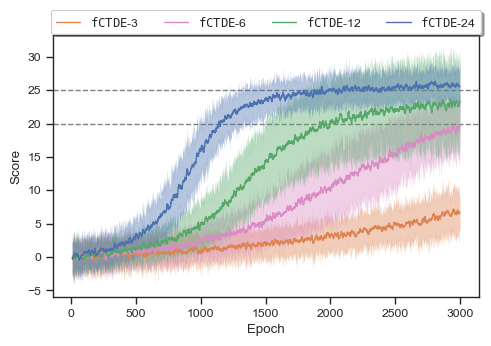

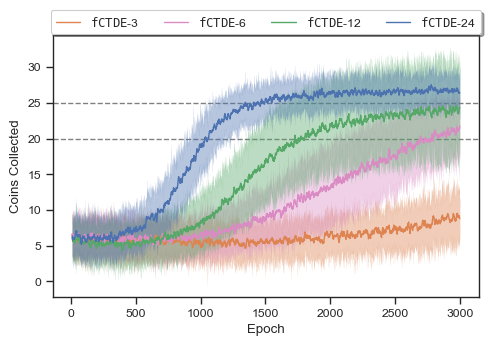

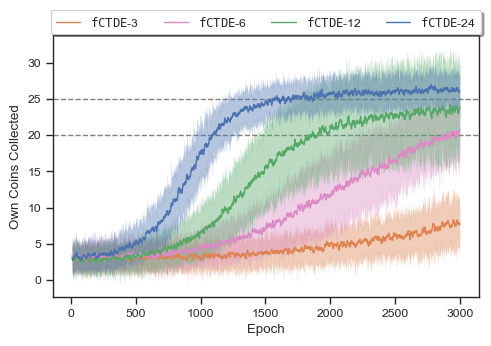

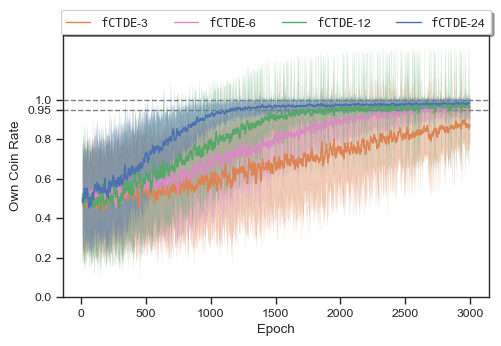


Figure config loaded: fig_coingame2_maa2c_pomdp_ablation_fctde from ../fig_coingame2_maa2c_pomdp_ablation_fctde.py
[report:y-threshold-max:20] $\mathtt{fCTDE}$-3 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{fCTDE}$-6 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{fCTDE}$-12 crosses y=20 at x=1798 (idx=1798)
[report:y-threshold-max:20] $\mathtt{fCTDE}$-24 crosses y=20 at x=1221 (idx=1221)
[report:y-threshold-max:25] $\mathtt{fCTDE}$-3 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{fCTDE}$-6 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{fCTDE}$-12 crosses y=25 at x=2658 (idx=2658)
[report:y-threshold-max:25] $\mathtt{fCTDE}$-24 crosses y=25 at x=1830 (idx=1830)
[report:y-max] $\mathtt{fCTDE}$-3 max value y=6.609999999999999 at x=2967 (idx=2967)
[report:y-max] $\mathtt{fCTDE}$-6 max value y=19.39 at x=2998 (idx=2998)
[report:y-max] $\mathtt{fCTDE}$-12 max value y=25.490000000000002 at x=2824 (idx=2824)
[report:y-max] $\mathtt{fCTDE}$-24 max value y=

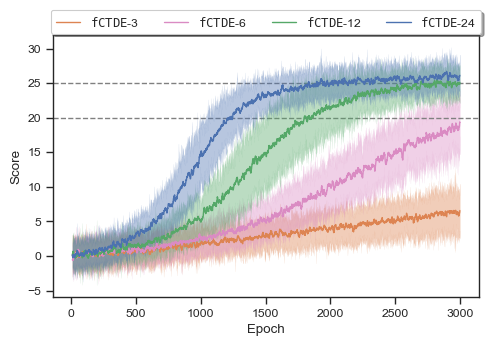

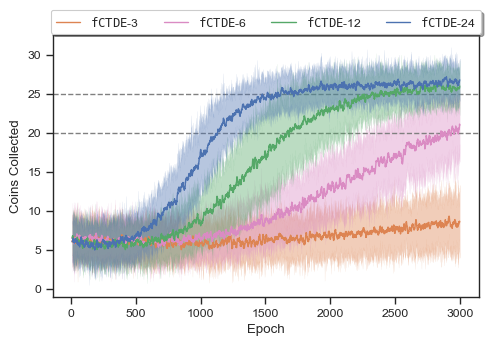

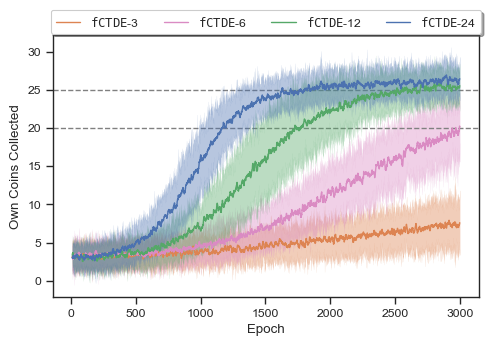

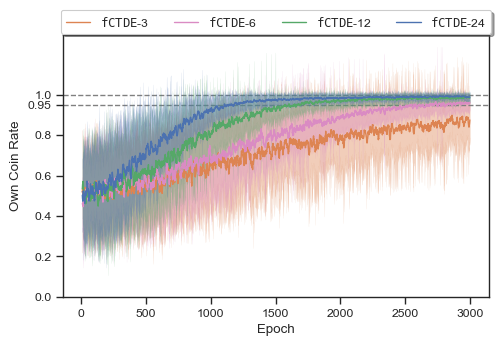


Figure config loaded: fig_coingame2_maa2c_mdp_ablation_sctde from ../fig_coingame2_maa2c_mdp_ablation_sctde.py
[report:y-threshold-max:20] $\mathtt{sCTDE}$-3 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{sCTDE}$-6 crosses y=20 at x=2808 (idx=2808)
[report:y-threshold-max:20] $\mathtt{sCTDE}$-12 crosses y=20 at x=1640 (idx=1640)
[report:y-threshold-max:20] $\mathtt{sCTDE}$-24 crosses y=20 at x=1076 (idx=1076)
[report:y-threshold-max:25] $\mathtt{sCTDE}$-3 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{sCTDE}$-6 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{sCTDE}$-12 crosses y=25 at x=2615 (idx=2615)
[report:y-threshold-max:25] $\mathtt{sCTDE}$-24 crosses y=25 at x=1772 (idx=1772)
[report:y-max] $\mathtt{sCTDE}$-3 max value y=9.01 at x=2982 (idx=2982)
[report:y-max] $\mathtt{sCTDE}$-6 max value y=21.07 at x=2996 (idx=2996)
[report:y-max] $\mathtt{sCTDE}$-12 max value y=25.3 at x=2631 (idx=2631)
[report:y-max] $\mathtt{sCTDE}$-24 max value y=26.2400000000000

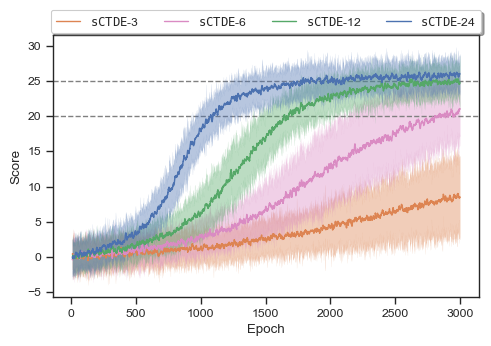

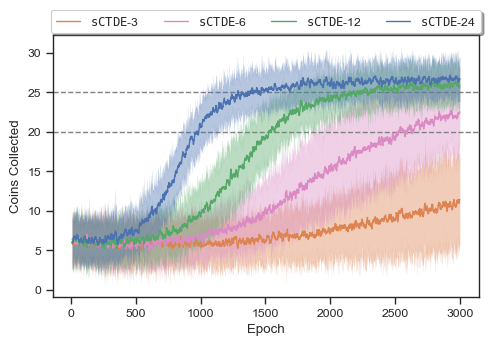

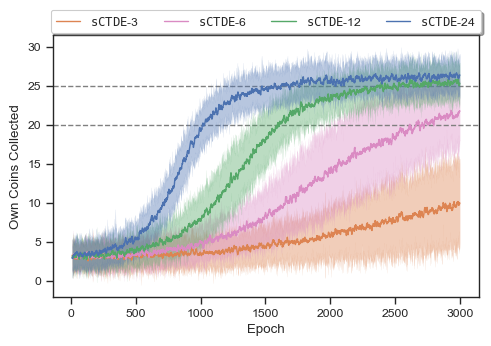

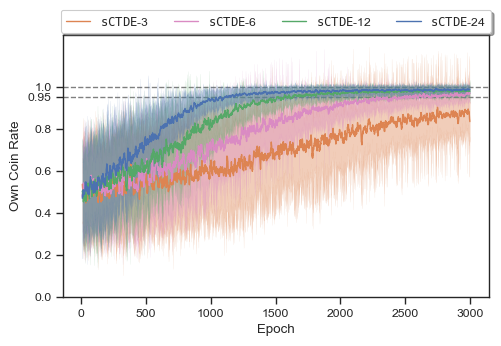


Figure config loaded: fig_coingame2_maa2c_pomdp_ablation_sctde from ../fig_coingame2_maa2c_pomdp_ablation_sctde.py
[report:y-threshold-max:20] $\mathtt{sCTDE}$-3 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{sCTDE}$-6 NEVER crosses y=20
[report:y-threshold-max:20] $\mathtt{sCTDE}$-12 crosses y=20 at x=1738 (idx=1738)
[report:y-threshold-max:20] $\mathtt{sCTDE}$-24 crosses y=20 at x=1127 (idx=1127)
[report:y-threshold-max:25] $\mathtt{sCTDE}$-3 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{sCTDE}$-6 NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{sCTDE}$-12 crosses y=25 at x=2750 (idx=2750)
[report:y-threshold-max:25] $\mathtt{sCTDE}$-24 crosses y=25 at x=1562 (idx=1562)
[report:y-max] $\mathtt{sCTDE}$-3 max value y=6.660000000000001 at x=2985 (idx=2985)
[report:y-max] $\mathtt{sCTDE}$-6 max value y=17.25 at x=2998 (idx=2998)
[report:y-max] $\mathtt{sCTDE}$-12 max value y=25.33 at x=2999 (idx=2999)
[report:y-max] $\mathtt{sCTDE}$-24 max value y=26.6 at x=280

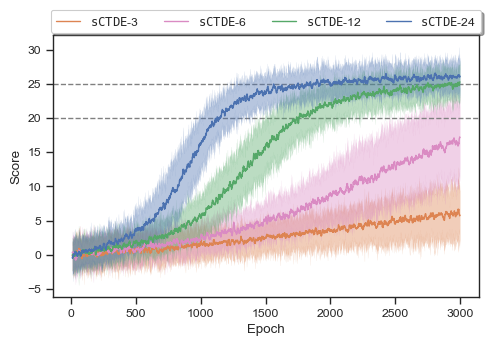

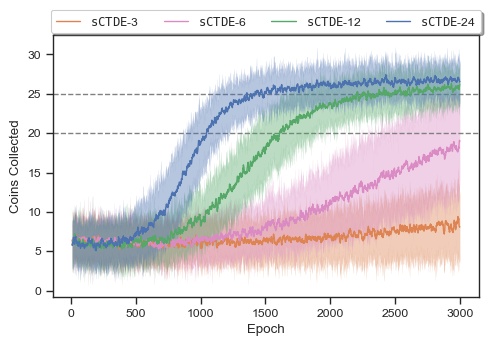

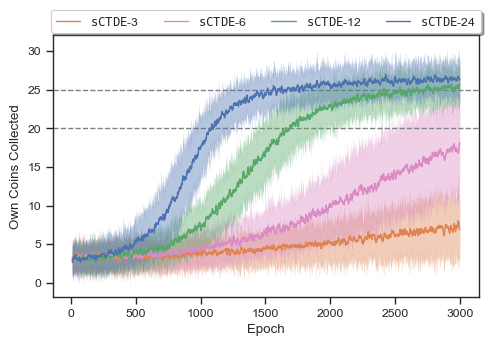

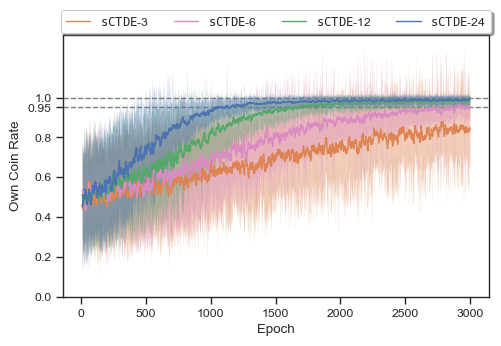

In [41]:
configs = [
    # # CoinGame.
    # '../figures/fig_maa2c_mdp.py',
    # '../figures/fig_maa2c_pomdp.py',
    # '../figures/fig_maa2c_mdp_entanglement_compare.py',
    # '../figures/fig_maa2c_pomdp_entanglement_compare.py',
    

    # # CartPole.
    # '../fig_cartpole_maa2c_mdp.py',
    
    # # CoinGame4.
    # '../fig_coingame4_maa2c_mdp.py',
    
    
    
    # Ablation study for CoinGame2.
    '../fig_coingame2_maa2c_mdp_ablation_fctde.py',
    '../fig_coingame2_maa2c_pomdp_ablation_fctde.py',
    '../fig_coingame2_maa2c_mdp_ablation_sctde.py',
    '../fig_coingame2_maa2c_pomdp_ablation_sctde.py',
]
for path in configs:
    path = Path(path)
    mod_name = f"{path.stem}"
    
    if mod_name in sys.modules:
        del sys.modules[mod_name]
    spec = importlib.util.spec_from_file_location(mod_name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    
    print(f"Figure config loaded: {mod_name} from {path}")
    
    generate_figures(mod.figures, mod.series)
    print(flush=True)